In [258]:
import sys
#print(sys.path)
# sys.path.insert(0, '/eos/user/c/czeh/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

The scikit-learn version is 1.5.1.
Python version
3.11.9 (main, Jun 24 2024, 14:32:54) [GCC 11.3.0]
Version info.
sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)


In [259]:
#from code import utils
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as pyg

import awkward as ak
import numpy as np
import uproot as uproot


%matplotlib inline

In [260]:
# use this to load the tree if some of file.keys() are duplicates ending with different numbers
def load_branch_with_highest_cycle(file, branch_name):

    # Get all keys in the file
    all_keys = file.keys()

    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]

    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")

    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))

    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]

    return branch

In [261]:
# input_folder = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv5Performance/CloseByPionPU/histo/"
input_folder = "/eos/user/c/czeh/"
files = glob.glob(f"{input_folder}/*.root")
print(files)
file = uproot.open(files[0])
print(file.keys())

alltracksters = load_branch_with_highest_cycle(file,'ticlDumper/trackstersCLUE3DHigh')
allclusters = load_branch_with_highest_cycle(file,'ticlDumper/clusters')
allsimtrackstersCP = load_branch_with_highest_cycle(file, 'ticlDumper/simtrackstersCP')
allassociations = load_branch_with_highest_cycle(file, 'ticlDumper/associations')
alltracks = load_branch_with_highest_cycle(file, 'ticlDumper/tracks')
print(alltracksters.show())
print(allclusters.show())

['/eos/user/c/czeh/histo_5963955_0.root']
['ticlDumper;1', 'ticlDumper/trackstersCLUE3DHigh;1', 'ticlDumper/trackstersTiclCandidate;1', 'ticlDumper/simtrackstersSC;1', 'ticlDumper/simtrackstersCP;1', 'ticlDumper/trackstersSuperclusteringDNN;1', 'ticlDumper/clusters;1', 'ticlDumper/candidates;1', 'ticlDumper/superclustering;1', 'ticlDumper/associations;1', 'ticlDumper/tracks;1', 'ticlDumper/simTICLCandidate;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | edm::EventID             | AsGroup(<TBranchElement 'ev...
event/run_           | uint32_t                 | AsDtype('>u4')
event/luminosityB... | uint32_t                 | AsDtype('>u4')
event/event_         | uint64_t                 | AsDtype('>u8')
NTracksters          | uint32_t                 | AsDtype('>u4')
NClusters            | uint32_t                 | AsDtype('>u4')
time              

In [262]:
node_feature_keys_before = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "raw_energy", "raw_em_energy", "time"]
data = alltracksters.arrays(node_feature_keys_before)
data

<Array [{barycenter_x: [...], ...}, ..., {...}] type='10 * {barycenter_x: v...'>

In [263]:
num_LCs = ak.count(alltracksters.arrays().vertices_indexes, axis=2)
data["num_LCs"] = num_LCs

In [264]:
data["z_min"] = ak.min(alltracksters.arrays().vertices_z, axis=2)
data["z_max"] = ak.max(alltracksters.arrays().vertices_z, axis=2)

In [265]:
hits = ak.to_list(np.zeros_like(data.num_LCs))
length = ak.to_list(np.zeros_like(data.num_LCs))
density = ak.to_list(np.zeros_like(data.num_LCs))

volume = 2*(3 - 1.5) * (2 * 47)
data["LC_density"] = data.num_LCs / volume

cluster_number_of_hits = allclusters.arrays().cluster_number_of_hits
cluster_layer_id = allclusters.arrays().cluster_layer_id
vertices_indexes = alltracksters.arrays().vertices_indexes
NTracksters = alltracksters.arrays().NTracksters

for i in tqdm(range(len(alltracksters.arrays()))):
    for j in range(alltracksters.arrays().NTracksters[i]):
        hits[i][j] = ak.sum(cluster_number_of_hits[i][vertices_indexes[i][j]])
        length[i][j] = (ak.max(cluster_layer_id[i][vertices_indexes[i][j]]) - ak.min(cluster_layer_id[i][vertices_indexes[i][j]])) / 47
        density[i][j] = NTracksters[i] / volume
        
data["num_hits"] = hits
data["length"] = length
data["trackster_density"] = density

100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


In [266]:
data["photon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 0]
data["electron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 1]
data["muon_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 2]
data["neutral_pion_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 3]
data["charged_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 4]
data["neutral_hadron_prob"] = alltracksters.arrays()["id_probabilities"][:, :, 5]

In [267]:
data[0]

<Record {barycenter_x: [...], ...} type='{barycenter_x: var * float32, bary...'>

In [268]:
node_feature_keys = ["barycenter_x", "barycenter_y", "barycenter_z", "barycenter_eta", "barycenter_phi", "eVector0_x", "eVector0_y", "eVector0_z",  "EV1", "EV2", "EV3", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "num_LCs", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "LC_density", "trackster_density", "time"]
thesis_feature_names = ["x", "y", "z", "eta", "phi", "eig_x", "eig_y", "eig_z",  "EV1", "EV2", "EV3", "sigmaPCA_x", "sigmaPCA_y", "sigmaPCA_z", "num_LC", "num_hits", "raw_energy", "raw_em_energy", "photon_prob", "electron_prob", "muon_prob", "neutral_pion_prob", "charged_hadron_prob", "neutral_hadron_prob", "z_min", "z_max", "LC_density", "trackster_density", "time"]

100%|██████████| 29/29 [00:13<00:00,  2.11it/s]
/tmp/ipykernel_318/3639755269.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


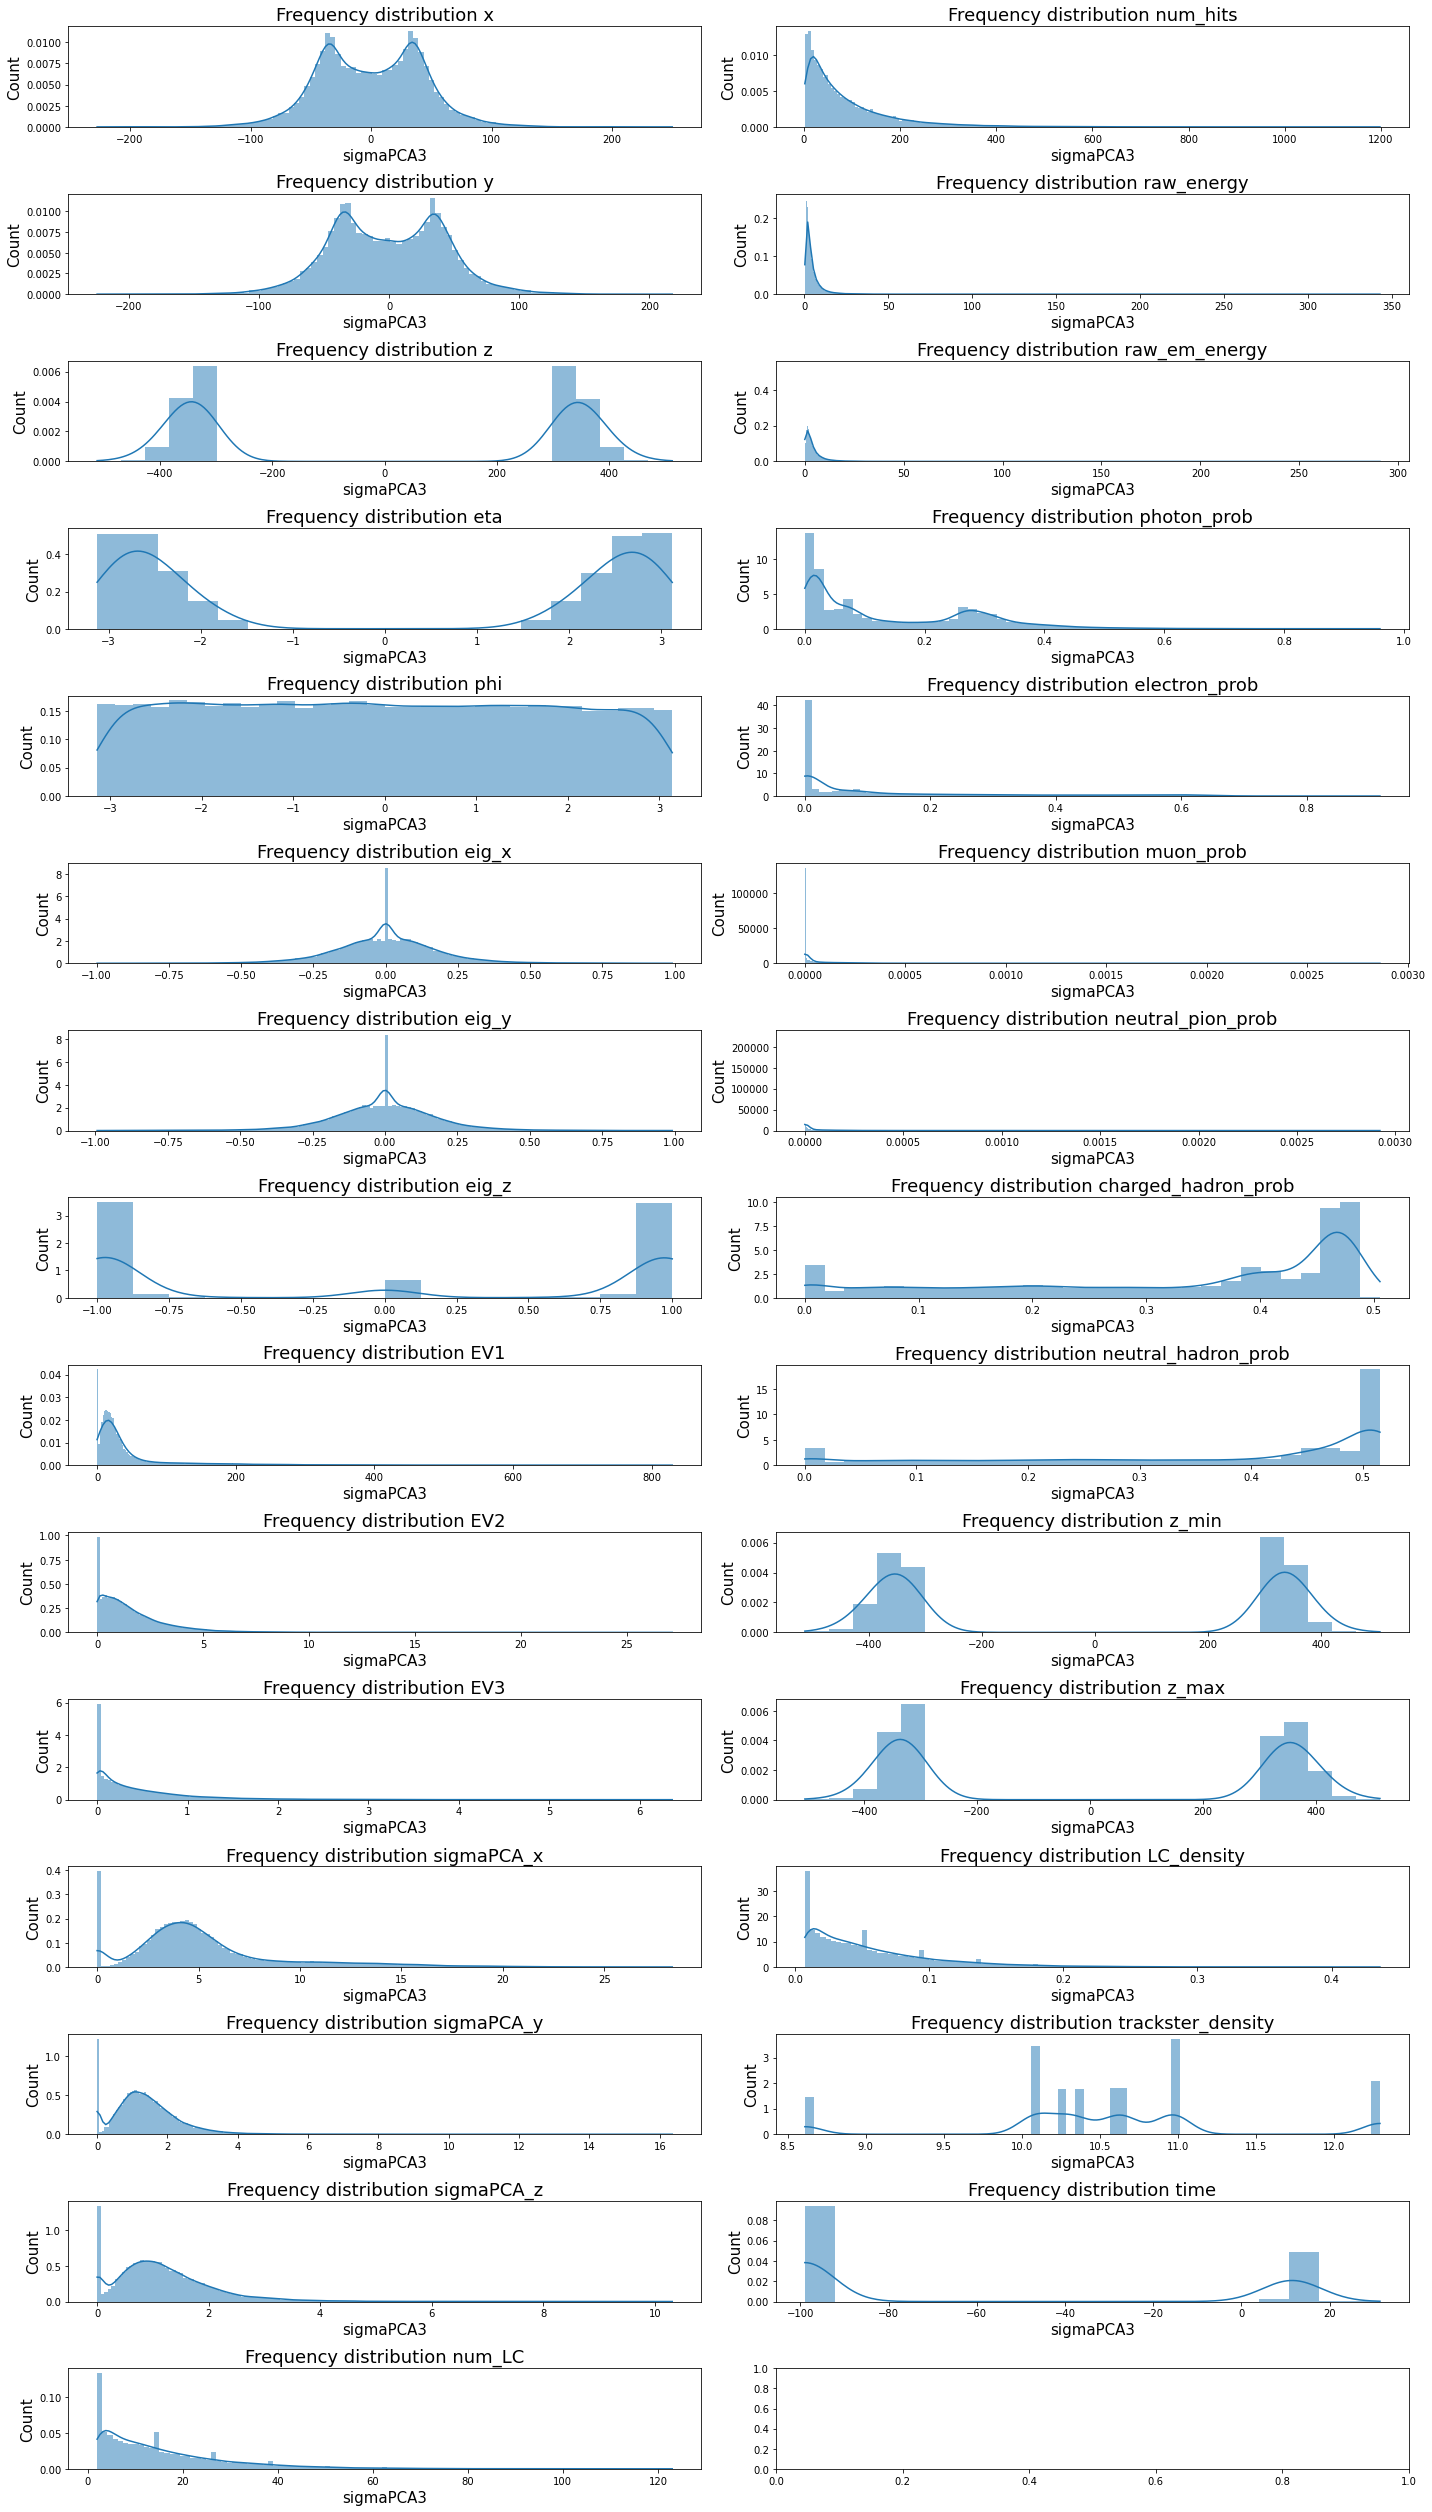

In [269]:
track_vals = []

scols = int(np.ceil(len(node_feature_keys)/2))
srows = 2
fig, axes = plt.subplots(scols, srows, figsize=(20, 35), constrained_layout=True)

for i in tqdm(range(len(node_feature_keys))):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    
    values = ak.flatten(data[node_feature_keys[i]])
    track_vals.append(values)
    sns.histplot(values, ax=axes[ax_col, ax_row], kde=True, stat="density", linewidth=0)
    axes[ax_col, ax_row].set_title('Frequency distribution '+ thesis_feature_names[i], fontsize=18)
    axes[ax_col, ax_row].set_xlabel(feature, fontsize=15)
    axes[ax_col, ax_row].set_ylabel('Count', fontsize=15)
    
fig.tight_layout()
plt.show()

In [270]:
track_vals = np.array(track_vals)

In [271]:
corr_matrix = np.corrcoef(track_vals)
print(corr_matrix.shape)

(29, 29)


Text(0.5, 1.0, 'Correlation Matrix of the Trackster Features')

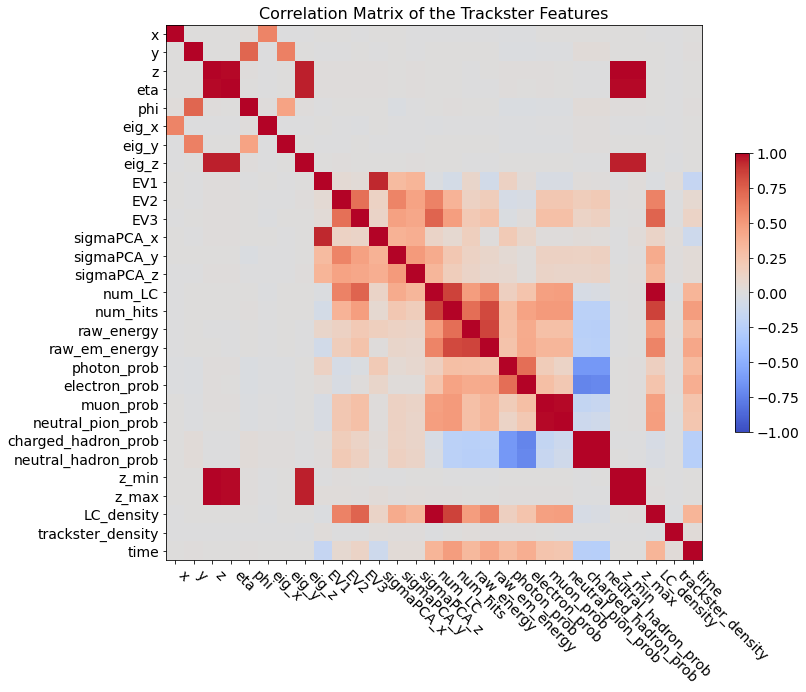

In [272]:
f = plt.figure(figsize=(12, 10))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14, rotation=-45, ha="left")
plt.yticks(range(len(thesis_feature_names)), thesis_feature_names, fontsize=14)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of the Trackster Features', fontsize=16)

In [291]:
nodes = np.zeros((NTracksters[0], len(node_feature_keys)))
for i, key in enumerate(node_feature_keys):
    nodes[:, i] = ak.to_numpy(data[0][key])
    
nodes

array([[-5.21461563e+01,  8.95173836e+00, -3.29654449e+02, ...,
         1.73758865e-01,  1.09574468e+01,  1.11185226e+01],
       [ 5.49269142e+01,  6.69366455e+00, -3.23208557e+02, ...,
         1.06382979e-02,  1.09574468e+01, -9.90000000e+01],
       [ 1.64634495e+01,  3.71177101e+01, -3.23307129e+02, ...,
         1.77304965e-02,  1.09574468e+01,  1.08888674e+01],
       ...,
       [ 1.86500000e+02, -1.79799252e+01,  4.68359711e+02, ...,
         1.06382979e-02,  1.09574468e+01, -9.90000000e+01],
       [ 3.13819695e+01, -5.52691574e+01,  4.80063812e+02, ...,
         1.06382979e-02,  1.09574468e+01, -9.90000000e+01],
       [ 8.93528442e+01, -1.49789839e+01,  4.84029541e+02, ...,
         7.09219858e-03,  1.09574468e+01, -9.90000000e+01]])